In [127]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [128]:
def get_spectrum_magnitude(img_in: np.ndarray):
    fft = np.fft.fft2(img_in)
    fft_shift = np.fft.fftshift(fft)
    result = np.log(np.abs(fft_shift))
    return result

SOSI = 5
class ForgeryDetector:
    def __init__(self, img_src: np.ndarray, N: int = 2, em_iterations: int = 10):
        self.img_src = img_src
        self.em_iterations = em_iterations
        self.N = N
        self.ALPHA_SIDE = 2 * self.N + 1
        
        self.img_gs = cv2.cvtColor(self.img_src, cv2.COLOR_BGR2GRAY).astype(np.float32)
        self.p0 = 1 / (self.img_gs.max() - self.img_gs.min())
        self.img_gs /= 255.
        self.img_gs_vec = self.img_gs.flatten().T
        
        self.Y = self.init_Y()
        self.Y_transposed = self.Y.T
        self.alpha = self.init_neighbourhood()
        self.sigma = 5.0

    def init_neighbourhood(self):
        neighbourhood = np.ones((self.ALPHA_SIDE, self.ALPHA_SIDE))
        neighbourhood[self.N, self.N] = 0
        total_cells = self.ALPHA_SIDE * self.ALPHA_SIDE
        neighbourhood /= (total_cells - 1)
        return neighbourhood
    
    def init_Y(self):
        '''
        :param img_in: source image
        :param N: neighbourhood size (see pdf file)
        :return: matrix of size (w*h, win_size), win_size = (2*N+1)^2 - 1,
        where each row represents win_size-sized window of the image as if it was flattened into 1-d array, but central element for each row is deleted (see pdf file)
        '''
        padded_img = np.pad(self.img_gs, self.N)
        window_shape = (self.ALPHA_SIDE, self.ALPHA_SIDE)
        Y = np.lib.stride_tricks.sliding_window_view(
            padded_img, window_shape
        ).reshape((-1, self.ALPHA_SIDE ** 2)) # reshape src array into a 2D array where each row contains nh_side ** 2 elements
        # delete center element of each row
        Y = np.delete(Y, Y.shape[1] // 2, axis=1)
        return Y
    
    def init_filter(self, Nh: int = 7):
        h = np.ones((Nh, Nh)) / (Nh ** 2)
        return h
    
    def EM(self, filter_kernel: np.ndarray, P_map: np.ndarray):
        # calc residual error
        err = cv2.filter2D(
            np.abs(self.img_gs - cv2.filter2D(self.img_gs, SOSI, self.alpha)),
            SOSI,
            filter_kernel
        )
        # expectation: calculating probability map
        p_coef = 1 / (self.sigma * np.sqrt(2 * np.pi))
        exppp = np.exp(-(err ** 2) / (2 * self.sigma ** 2))
        # print(exppp.shape)
        np.multiply(p_coef, np.exp(-(err ** 2) / (2 * self.sigma ** 2)), P_map)
        # P_map = p_coef * np.exp(-(err ** 2) / (2 * self.sigma ** 2))
        
        # maximization
        w = P_map / (P_map + self.p0)
        self.sigma = np.sqrt(np.sum(w * err**2) / w.sum())
        W = w.flatten()
        self.alpha = (
            np.linalg.inv((self.Y_transposed * W) @ self.Y) @ self.Y_transposed * W
        ) @ self.img_gs_vec
        self.alpha = (np.insert(self.alpha, self.alpha.shape[0] // 2, 0)
                      .reshape((self.ALPHA_SIDE, self.ALPHA_SIDE)))
    
    def run(self):
        kernel = self.init_filter()
        P_map = np.zeros((self.img_gs.shape))
    
        for _ in range(self.em_iterations):
            self.EM(kernel, P_map)
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 18))
        ax[0].imshow(cv2.cvtColor(self.img_src, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Source')
        ax[1].imshow(P_map, cmap='gray')
        ax[1].set_title('Probability map') 
        ax[2].imshow(get_spectrum_magnitude(P_map), cmap='gray')
        ax[2].set_title('Spectrum magnitude')
        fig.tight_layout()

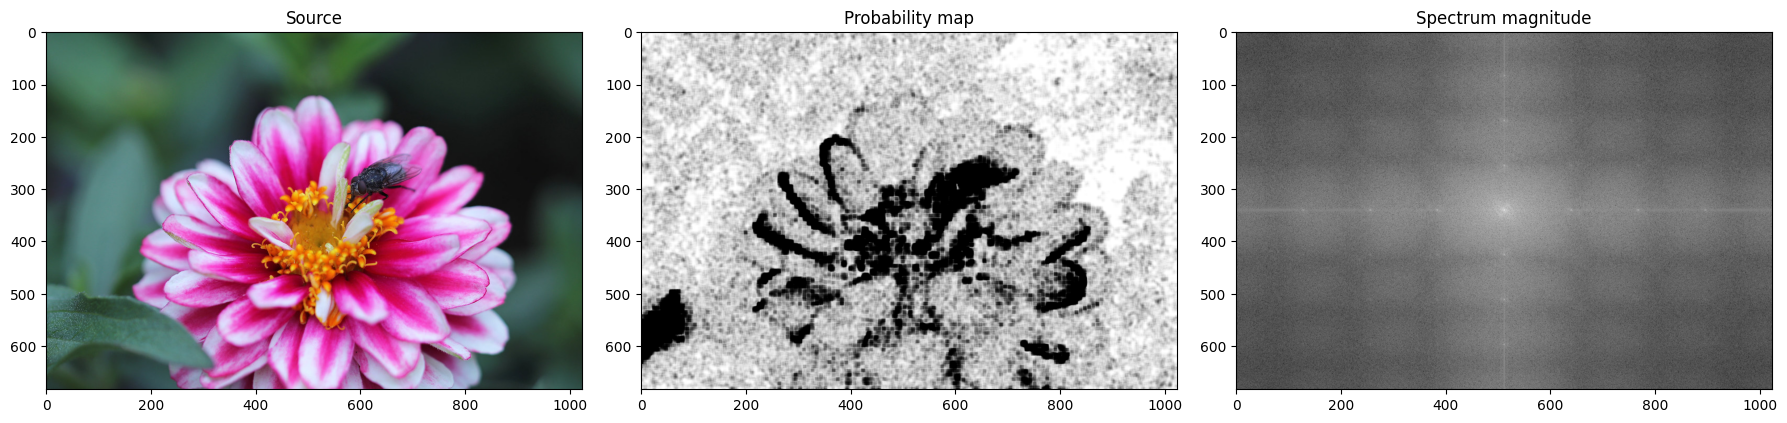

In [129]:
img_src = cv2.imread('image1.jpg')
fd = ForgeryDetector(img_src, em_iterations = 10)
fd.run()

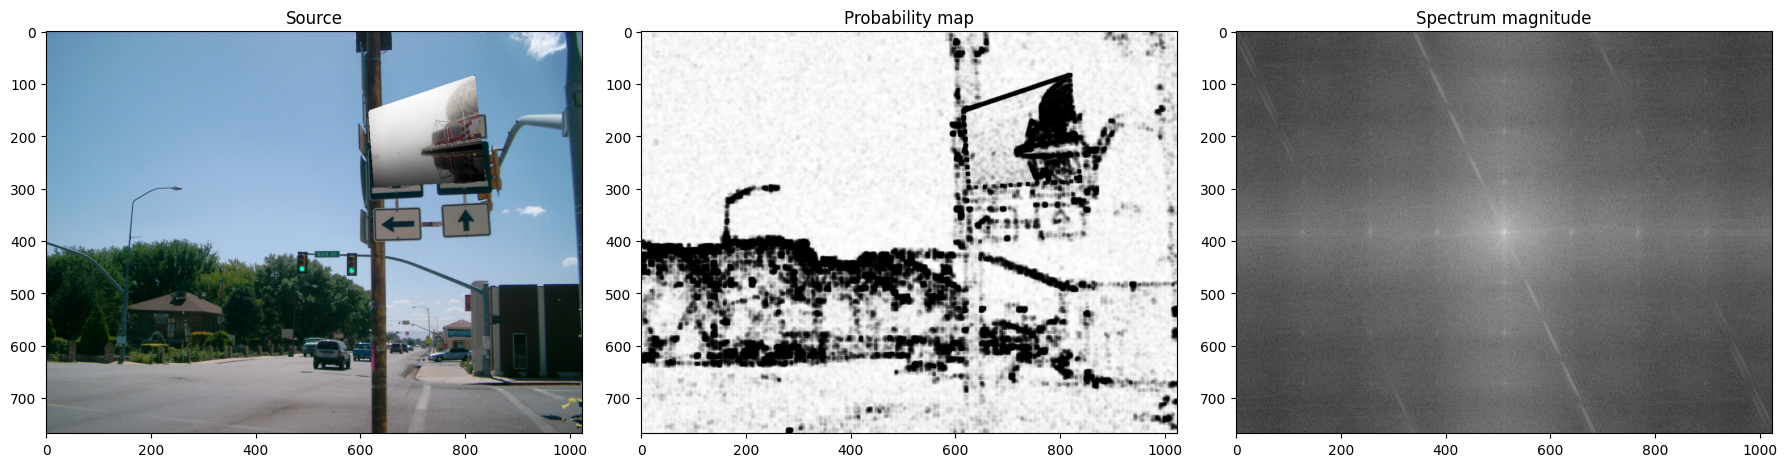

In [130]:
img_src = cv2.imread('image2.png')
fd = ForgeryDetector(img_src, em_iterations = 10)
fd.run()